# Error analysis notebook (test data)

## Import packages

In [1]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum

import json


## Set filepaths

In [31]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_meta_99_1_train.json'
eval_result_hlevel = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_99_1_train_hlevel.tsv'
eval_result_level = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_99_1_train_level.tsv'
gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'
est_rel_meta_p = '../reranking/resources/relevances/Training_rel_scores_model_A.csv'
annotations = '../pre_pre_processing/resources/merged-annotations.json'
mapping = '../reranking/resources/mappings/training_doc_to_author.json'

## Prepare dataframes

In [32]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result dfs
ehldf = pd.read_csv(eval_result_hlevel, sep='\t', names=['key', 'qid', 'value'])
ehldf = ehldf.pivot(index='qid', columns='key', values='value')

eldf = pd.read_csv(eval_result_level, sep='\t', names=['key', 'qid', 'value'])
eldf = eldf.pivot(index='qid', columns='key', values='value')


# est rel df
est_rel_meta = pd.read_csv(est_rel_meta_p)
est_rel_meta.head()

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

# doc to author and reverse mapping
with open(mapping) as fp:
    doc_to_author = json.load(fp)
alldocs = rdf.explode('ranking')['ranking'].drop_duplicates().to_list()
for doc in alldocs:
    if not doc in doc_to_author:
        doc_to_author[doc] = []
    
author_to_doc = {}
for doc, aulist in doc_to_author.items():
    for au in aulist:
        if not au in author_to_doc:
            author_to_doc[au] = []
        author_to_doc[au] = author_to_doc[au] + [doc]

In [33]:
rdf.head(2)

,q_num,qid,ranking
0,0.0,5438,"[b2fdee22aa02477292b858fbafcb418932732bce, 993..."
1,0.1,5438,"[b2fdee22aa02477292b858fbafcb418932732bce, 993..."


In [34]:
gtdf.head(2)

,qid,query,frequency,documents,doc_id,doc_rel
0,5438,cloud computing,0.000057,{'doc_id': '3e19046c665867bbe557685da60738a407...,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,0.000057,{'doc_id': '7ef08f1fa127af817cdfd9d3bd00bdf60e...,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [35]:
reldf.head(2)

,qid,query,doc_id,doc_rel
0,5438,cloud computing,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [36]:
ehldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.149930,2.873259,2.278765
258,0.575252,1.034694,0.661701


In [37]:
eldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.211055,3.319766,2.490167
258,0.459391,2.206123,1.346999


In [38]:
adf.head(2)

,id,missing_authors,authors,name,wiki,country,type,valid,auth_id,h_index,level,region
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David M. Szymanski', 'wiki': 'Texas ...",David M. Szymanski,Texas A&M University,US,academic,True,50215565.0,9.0,Advanced,Americas
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David H. Henard', 'wiki': 'North Car...",David H. Henard,North Carolina State University,US,academic,True,115002169.0,8.0,Advanced,Americas


In [39]:
edf_m = pd.merge(ehldf.sort_values(by='difference').reset_index().reset_index(),eldf.sort_values(by='difference').reset_index().reset_index(),on='qid')
edf_m = edf_m.rename({'index_x':'difficulty hlevel', 'index_y':'difficulty econ level'},axis=1)
edf_m.head()

key,difficulty hlevel,qid,difference_x,disparity_x,relevance_x,difficulty econ level,difference_y,disparity_y,relevance_y
0,0,132049,0.002449,1.424547,1.405493,0,0.002449,1.424547,1.405493
1,1,71096,0.016197,2.031633,1.896955,1,0.015298,2.030656,1.896917
2,2,27825,0.052606,0.884476,0.720133,3,0.039982,1.168747,0.963395
3,3,52728,0.054472,1.029968,0.832439,17,0.099483,1.006566,0.725675
4,4,15395,0.056473,2.091260,1.901703,2,0.036086,2.066015,1.899146


In [40]:
edf = edf_m.copy()
edf['difference'] = edf.apply(lambda row: (row.difference_x + row.difference_y)/2, axis=1)
edf['disparity'] = edf.apply(lambda row: (row.disparity_x + row.disparity_y)/2, axis=1)
edf['relevance'] = edf.apply(lambda row: (row.relevance_x + row.relevance_y)/2, axis=1)

edf = edf.sort_values(by='difference')[['qid','difference', 'disparity', 'relevance']]
edf.head()

key,qid,difference,disparity,relevance
0,132049,0.002449,1.424547,1.405493
1,71096,0.015747,2.031144,1.896936
4,15395,0.046280,2.078638,1.900424
2,27825,0.046294,1.026612,0.841764
9,54538,0.070638,1.173170,0.957303


## Extract information for specific query

Helper methods.

In [41]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [42]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)


## Methods

In [43]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [44]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=True)

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

### Methods count per rank

In [45]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [46]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [47]:
def plot_rel_nonrel_per_rank_per_relkind(data,num_rel,regline=False):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    pi2 = iter(sns.color_palette('dark'))
    f = next(pi)
    f2 = next(pi2)
    s = next(pi)
    s2 = next(pi2)
    next(pi)
    next(pi2)
    t = next(pi)
    t2 = next(pi2)

    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')

    colorsf = [f] * num_rel + [f2] * (len(data) - num_rel)
    colorss = [s] * num_rel + [s2] * (len(data) - num_rel)
    
    sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],palette=sns.color_palette(colorsf))
    sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],palette=sns.color_palette(colorss))

    if regline:
        colorst = [t] * num_rel + [t2] * (len(data) - num_rel)
        sns.regplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0], scatter_kws={"s": 0}, palette=sns.color_palette(colorst))
        sns.regplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1], scatter_kws={"s": 0},palette=sns.color_palette(colorst))
    return fig


In [48]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,num_rel_docs,regline=regline)
    fig.suptitle(f"(Non-)relevant documents per rank for {qid}, top={num_rel_docs}")
    

### Methods doc occurrence in top positions

In [49]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [50]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

### Methods number of times a doc is in a top position

In [51]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [52]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)
    
    m = pd.merge(unpacked_df,relevance_df[['doc_id','doc_rel']],on='doc_id',how='left')
    return m.drop_duplicates()

In [53]:
def document_pos_count_df_for_qid(qid,ranking,relevance):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)

    
    doc_position_counts = count_pos_of_documents(subranking, num_rel_docs)
    doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
    return doc_pos_count_df
    

In [54]:
def plot_doc_pos_count(data,numrel,numnrel,sortby=['count'],no_author_ids=None):
    """Plot how many times each document occurred in the top and bottom positions."""
    
    
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={numrel})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos].sort_values(by=sortby,ascending=False)
        
     
        
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        
        if no_author_ids:
            thisaxdata['secondcount'] = thisaxdata.apply(lambda row: row['count'] if row['doc_id'] in no_author_ids else 0, axis=1)
            sns.barplot(x="doc_labels", y="secondcount",palette=clrs, data=thisaxdata,ax=ax[i],hatch='//')
     
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
        
  
    return fig


In [55]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance,sortby=['count'], no_author_ids=None):
    doc_pos_count_df = document_pos_count_df_for_qid(qid,ranking,relevance)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    fig = plot_doc_pos_count(doc_pos_count_df,num_rel_docs,num_nonrel_docs,sortby=sortby,no_author_ids=no_author_ids)

    fig.suptitle(f"Document position counts {qid}")

# Anslysi

In [61]:
docs = reldf.doc_id.drop_duplicates().to_list()

In [63]:
noauth_docs = []
for doc in docs:
    if not doc_to_author[doc]:
        noauth_docs.append(doc)

In [71]:
reldf[(reldf.qid ==71096) & (reldf.doc_id == '30a698ba5648295c91f00545326931eaf07b00be')]

,qid,query,doc_id,doc_rel
17,71096,transtheoretical model,30a698ba5648295c91f00545326931eaf07b00be,0


In [75]:
est_rel_meta[(est_rel_meta.qid ==71096) & (est_rel_meta.doc_id == '30a698ba5648295c91f00545326931eaf07b00be')]

,qid,doc_id,relevance,est_relevance
448,71096,30a698ba5648295c91f00545326931eaf07b00be,0,0.069391


In [78]:
est_rel_meta[(est_rel_meta.qid ==71096)].sort_values(by='est_relevance',ascending=False)

,qid,doc_id,relevance,est_relevance
429,71096,e733c8eac41129ceaed9eadf06108119a3752894,0,0.255103
459,71096,cfa64338705a4903b3d38ae98901dc21183bf86c,0,0.224708
434,71096,f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a,0,0.224066
456,71096,77f576dd5df8bf19facce8edd20acf1d9a3fc75f,0,0.220324
432,71096,6afc97668839a439e6858691ada76c9ddf798c2a,1,0.218468
443,71096,bbf84c2e04321f3f5813cdc91978a186727bbe05,0,0.214495
454,71096,00525dd393d8a3a72e584eda8328ace8d43f3c0e,1,0.209185
451,71096,79c270ab702bdb568b42044c5516eb702c0c9854,0,0.193512
453,71096,bd15b65ce7b716cbdaaeee63d0f5a7e75300774d,0,0.186111
430,71096,ffccdae350cc206d3ae0012de73d8ee74fb59df1,0,0.183386


In [85]:
es = Elasticsearch()

In [86]:
es.search(index='semanticscholar2020og', body={"query": {"ids" : {"values" : ['30a698ba5648295c91f00545326931eaf07b00be']}}})


{'took': 646,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 0, 'relation': 'eq'},
  'max_score': None,
  'hits': []}}

In [89]:
es.search(index='semanticscholar2020og', body={"query": {"ids" : {"values" : ['4fbeb21f5e8865df969f65801c3102abd283ae79']}}})


{'took': 641,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '4fbeb21f5e8865df969f65801c3102abd283ae79',
    '_score': 1.0,
    '_source': {'title': 'Substitutional Reality: Using the Physical Environment to Design Virtual Reality Experiences',
     'paperAbstract': "Experiencing Virtual Reality in domestic and other uncontrolled settings is challenging due to the presence of physical objects and furniture that are not usually defined in the Virtual Environment. To address this challenge, we explore the concept of Substitutional Reality in the context of Virtual Reality: a class of Virtual Environments where every physical object surrounding a user is paired, with some degree of discrepancy, to a virtual counterpart. We present a model of potential substitutions and validate it in two user s

In [88]:
est_rel_meta[(est_rel_meta.qid ==27825) & (est_rel_meta.doc_id == '4fbeb21f5e8865df969f65801c3102abd283ae79')]

,qid,doc_id,relevance,est_relevance
1410,27825,4fbeb21f5e8865df969f65801c3102abd283ae79,1,0.188635


In [136]:
temp = est_rel_meta[(est_rel_meta.qid ==27825)].sort_values(by='est_relevance',ascending=False).copy()

In [137]:
temp['auth'] = temp.doc_id.apply(lambda row: doc_to_author[row])

In [134]:
pd.options.display.max_colwidth = 1000

In [138]:
temp['auth'].apply(lambda row: len(row)).mean()

3.1627906976744184

In [129]:
temp

,qid,doc_id,relevance,est_relevance,auth
1413,27825,42026ca49b217207cc61f52a1523d3a156b17f77,1,0.260105,[1683060]
1423,27825,7c6da0d6c8f09d638e2fcab63efbde2e21c0e2d4,1,0.232818,"[123555217, 34437150, 1716343]"
1418,27825,e0f9362543791a3fe9c745dc95f725caff0ea9a9,1,0.229577,"[3275930, 51349722]"
1402,27825,f2739b0f1ebec5f06eec305b77318142c8871f8a,0,0.227518,[1795780]
1394,27825,f122f6bd5d736041ca10368fdf3e5f9efb466531,1,0.222911,"[145791611, 40247030]"
1417,27825,050356a2b470932ee616a6013e8f632acac5535f,1,0.215864,"[5055848, 116169608]"
1399,27825,e33657412d495f4332c136fc7c9d0fb6b2ba493a,0,0.214617,"[1398916250, 1758576]"
1403,27825,4252f1027db03183fc00b7a8bbfd5c29bc126dc4,1,0.209585,"[4333528, 9870913, 12169610, 37436682, 32398833, 2543084, 6515724]"
1406,27825,8d0cfe3ae398d3b8fed86488a55c0566cf9e0092,0,0.202368,"[1729869, 1728765]"
1415,27825,af5a71cd9dcde6e19c7430c9ea8c0f3c42f9844f,1,0.199870,"[35960950, 143687087]"


In [ ]:
temp = temp.explode('auth')


In [119]:
complist = temp[temp.doc_id == 'e8ae8f15f943516b243769943104b60afa99bd64'].auth.drop_duplicates().to_list()

In [ ]:
temp[temp['auth'].isin(['34662879','2520424', '4919595'])]

,qid,doc_id,relevance,est_relevance,auth
1424,27825,e8ae8f15f943516b243769943104b60afa99bd64,0,0.18973,2101815
1424,27825,e8ae8f15f943516b243769943104b60afa99bd64,0,0.18973,2633299
1424,27825,e8ae8f15f943516b243769943104b60afa99bd64,0,0.18973,48961250
1424,27825,e8ae8f15f943516b243769943104b60afa99bd64,0,0.18973,17039306
1424,27825,e8ae8f15f943516b243769943104b60afa99bd64,0,0.18973,1894430


In [120]:
temp[temp['auth'].isin(['34662879','2520424', '4919595'])]

,qid,doc_id,relevance,est_relevance,auth
1410,27825,4fbeb21f5e8865df969f65801c3102abd283ae79,1,0.188635,34662879
1410,27825,4fbeb21f5e8865df969f65801c3102abd283ae79,1,0.188635,2520424
1410,27825,4fbeb21f5e8865df969f65801c3102abd283ae79,1,0.188635,4919595


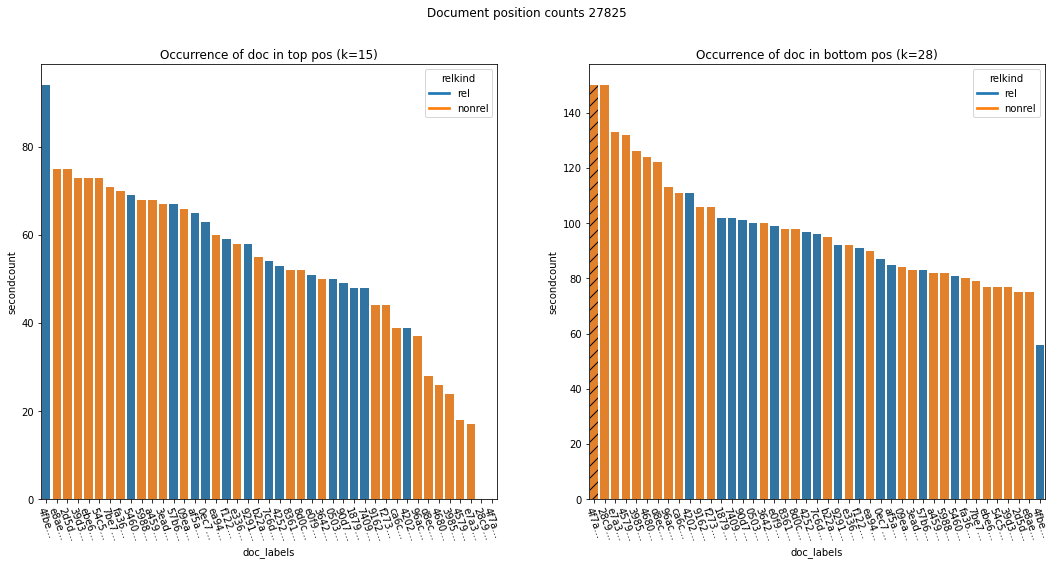

In [94]:
    plot_doc_pos_count_for_qid(27825, rdf, reldf, no_author_ids=noauth_docs)

In [87]:
est_rel_meta[(est_rel_meta.qid ==27825)].sort_values(by='est_relevance',ascending=False)

,qid,doc_id,relevance,est_relevance
1413,27825,42026ca49b217207cc61f52a1523d3a156b17f77,1,0.260105
1423,27825,7c6da0d6c8f09d638e2fcab63efbde2e21c0e2d4,1,0.232818
1418,27825,e0f9362543791a3fe9c745dc95f725caff0ea9a9,1,0.229577
1402,27825,f2739b0f1ebec5f06eec305b77318142c8871f8a,0,0.227518
1394,27825,f122f6bd5d736041ca10368fdf3e5f9efb466531,1,0.222911
1417,27825,050356a2b470932ee616a6013e8f632acac5535f,1,0.215864
1399,27825,e33657412d495f4332c136fc7c9d0fb6b2ba493a,0,0.214617
1403,27825,4252f1027db03183fc00b7a8bbfd5c29bc126dc4,1,0.209585
1406,27825,8d0cfe3ae398d3b8fed86488a55c0566cf9e0092,0,0.202368
1415,27825,af5a71cd9dcde6e19c7430c9ea8c0f3c42f9844f,1,0.199870


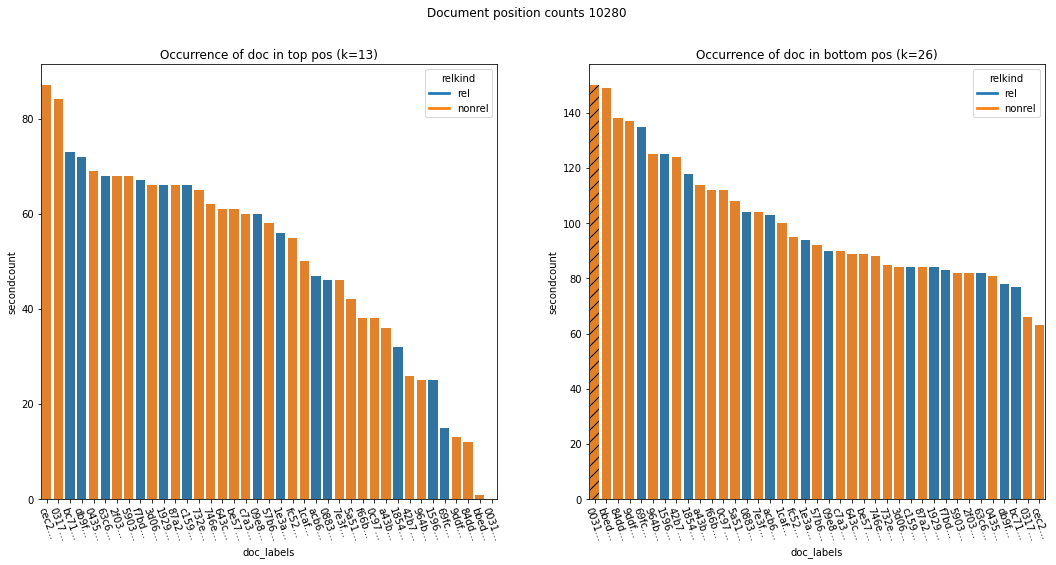

In [133]:
    plot_doc_pos_count_for_qid(10280, rdf, reldf, no_author_ids=noauth_docs)

In [139]:
temp = est_rel_meta[(est_rel_meta.qid ==10280)].sort_values(by='est_relevance',ascending=False).copy()
temp

,qid,doc_id,relevance,est_relevance
4290,10280,1854d80a095c32aaa524e50d07756a51493d5917,1,0.244617
4313,10280,0c973f1c28a925bce86b2817ea83e665a4e5c95a,0,0.243355
4311,10280,f66b538d20ffc839937e5fd10fccf75ffb526c0a,0,0.235200
4288,10280,964b454c92d1733c1d8265018e506bcdece934de,0,0.227880
4297,10280,0883900808aa6fccc06c11e27521ee43af376d7a,1,0.202723
4299,10280,acb678bdd7634055de18d0b89bb6a4890e6a0306,1,0.202195
4319,10280,1caf808ea8afd1b548bb3dfcbeae39a41fa5992e,0,0.201279
4317,10280,be57ba746b8fec268025df6afc68536fbd0188d8,0,0.197552
4296,10280,c7a3699cbb6e8ea60edabb60c0407883e6ed33f2,0,0.191689
4306,10280,643cc46616580faba24162bfca4bba175fb70384,0,0.190303


In [140]:
temp['auth'] = temp.doc_id.apply(lambda row: doc_to_author[row])
temp

,qid,doc_id,relevance,est_relevance,auth
4290,10280,1854d80a095c32aaa524e50d07756a51493d5917,1,0.244617,"[5757055, 6630263, 9332657, 3886297, 30912607]"
4313,10280,0c973f1c28a925bce86b2817ea83e665a4e5c95a,0,0.243355,"[2953278, 51940867, 6261994, 2272653, 49096766, 144814012, 5581614, 6246797]"
4311,10280,f66b538d20ffc839937e5fd10fccf75ffb526c0a,0,0.235200,"[5757055, 104914927, 6630263, 47903550, 6935346, 145734315, 9332657]"
4288,10280,964b454c92d1733c1d8265018e506bcdece934de,0,0.227880,"[4477164, 3777660, 6116727]"
4297,10280,0883900808aa6fccc06c11e27521ee43af376d7a,1,0.202723,"[49214932, 3582352, 5218643, 4547060]"
4299,10280,acb678bdd7634055de18d0b89bb6a4890e6a0306,1,0.202195,"[34205896, 153200016, 4059719, 8314128, 49722635, 51257346, 152899919, 46919283, 145103153, 12572473]"
4319,10280,1caf808ea8afd1b548bb3dfcbeae39a41fa5992e,0,0.201279,"[48449409, 144846551, 14315571, 35213763, 2629725, 4036480]"
4317,10280,be57ba746b8fec268025df6afc68536fbd0188d8,0,0.197552,"[120395155, 1897003, 40482050, 48176749]"
4296,10280,c7a3699cbb6e8ea60edabb60c0407883e6ed33f2,0,0.191689,"[144397495, 29343685, 144965974, 8964463, 48362653, 49445120, 49973284, 9505945, 144212854, 46623680, 47057507, 2914068, 1387470315, 143805765, 145177300, 153008184, 1693443]"
4306,10280,643cc46616580faba24162bfca4bba175fb70384,0,0.190303,"[89562706, 152860723, 49315897, 46280556, 3571698]"


In [141]:
temp['auth'].apply(lambda row: len(row)).mean()

8.282051282051283

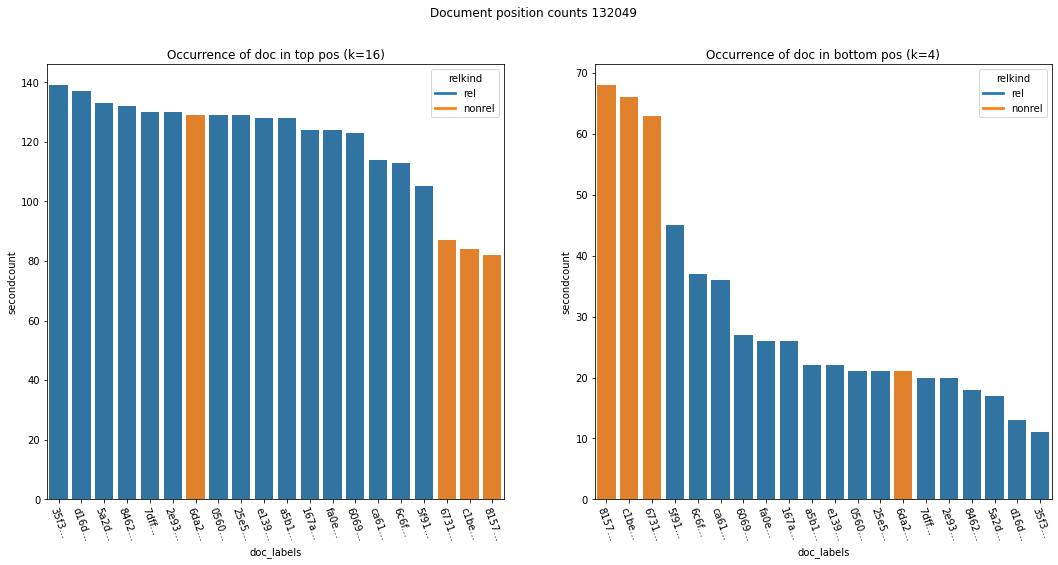

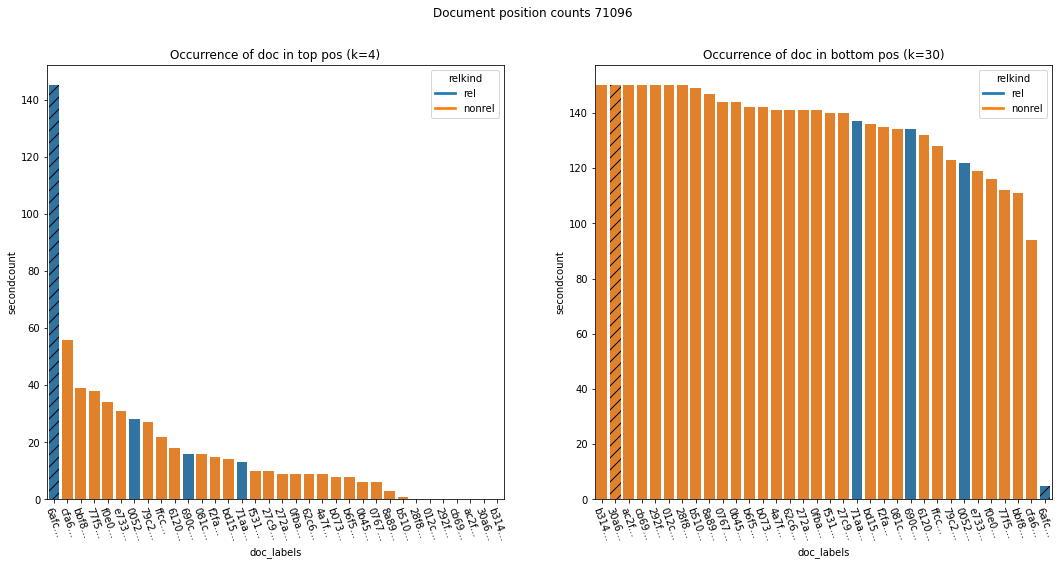

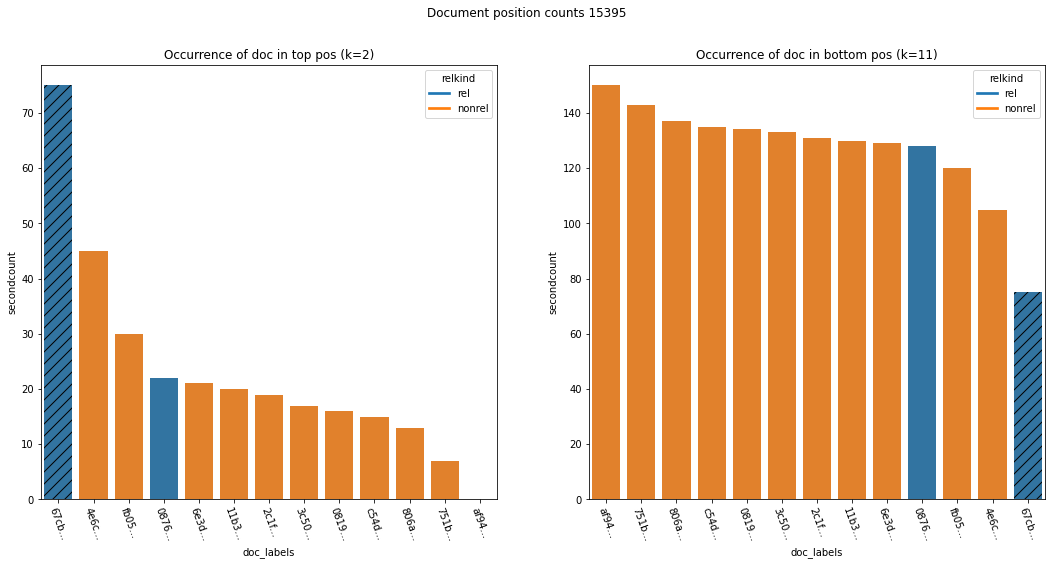

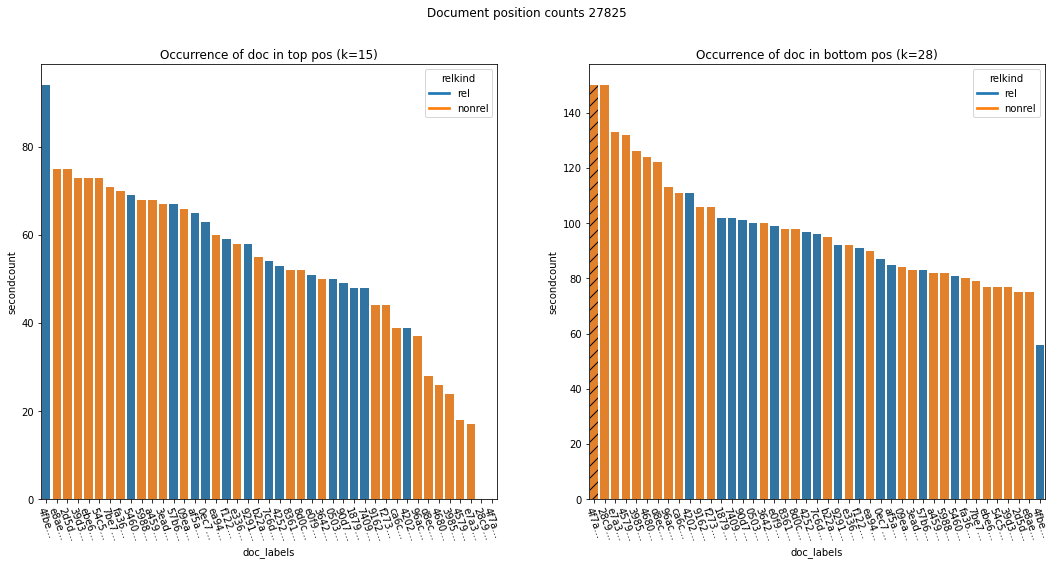

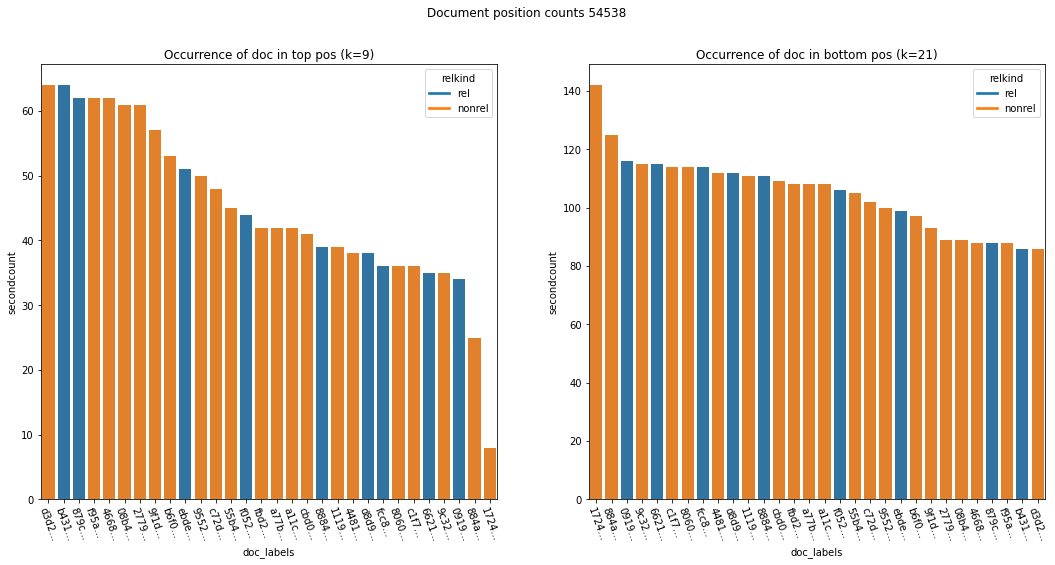

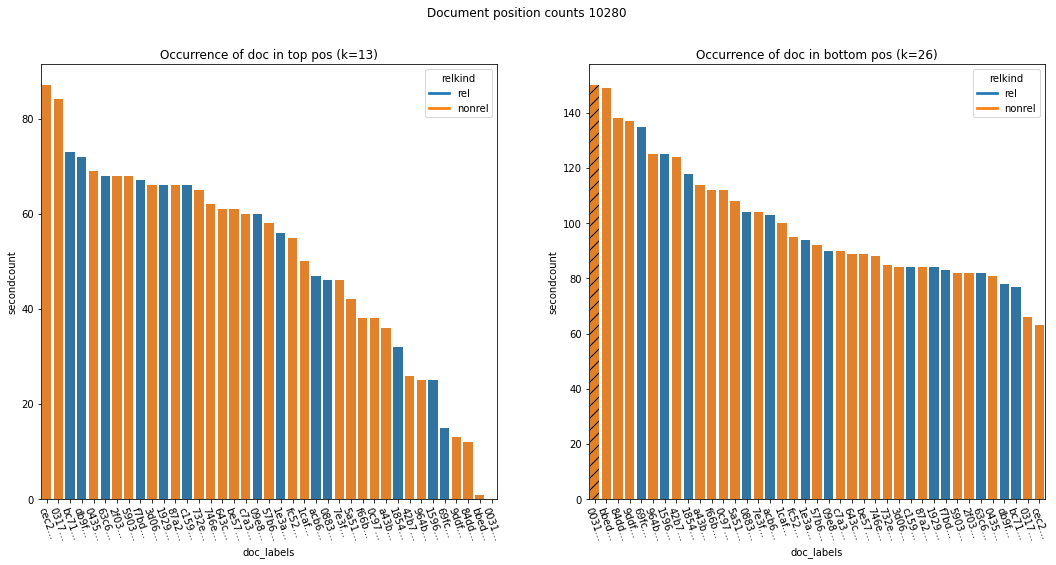

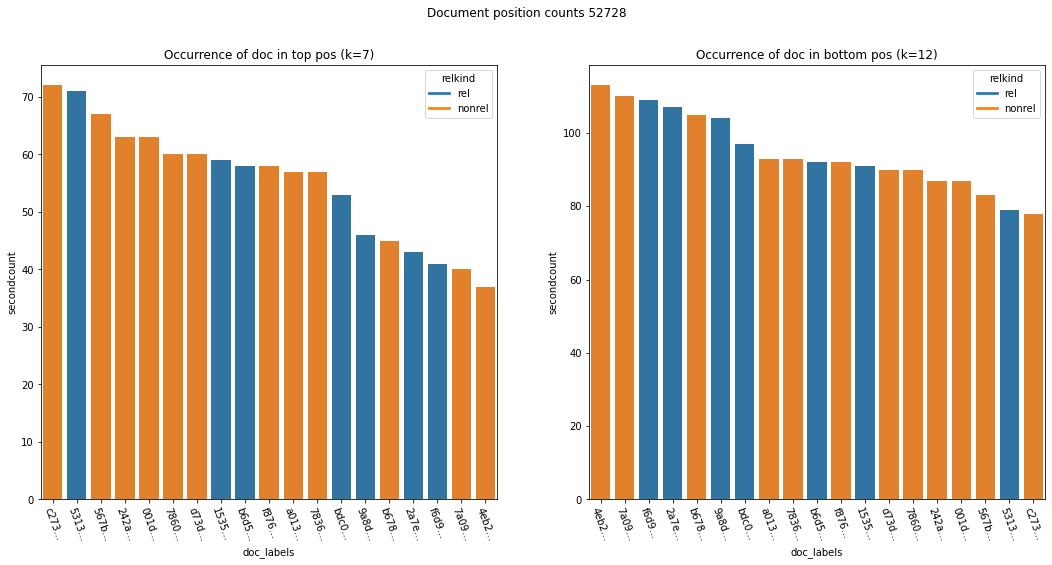

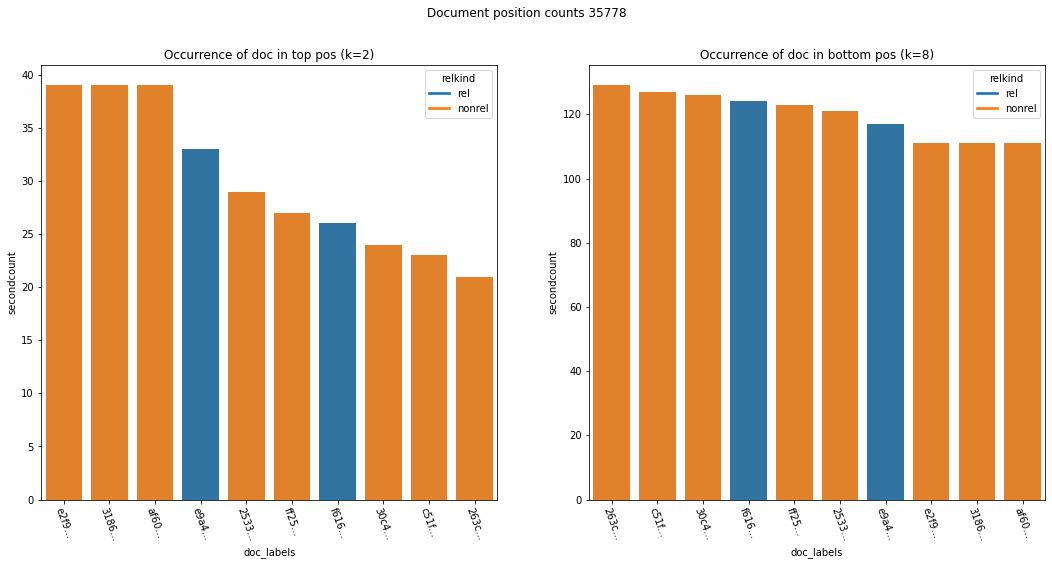

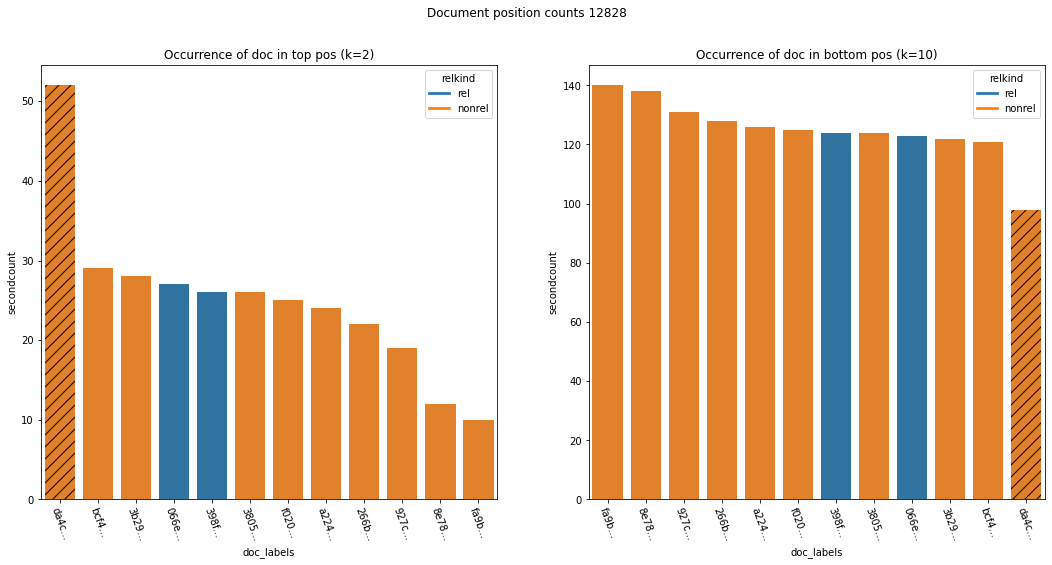

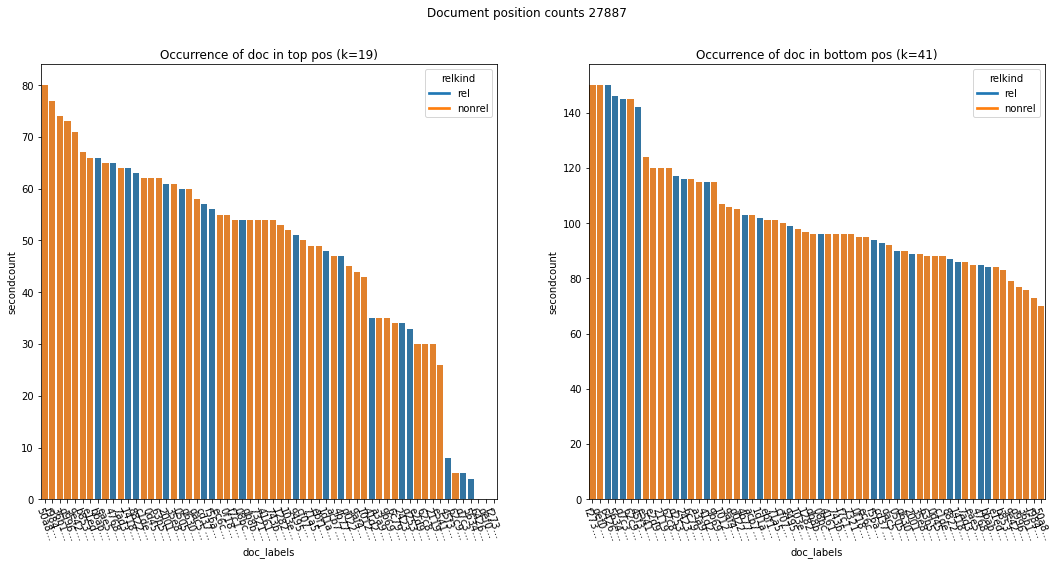

In [65]:
for qid in edf.head(10).qid.to_list():
    plot_doc_pos_count_for_qid(qid, rdf, reldf, no_author_ids=noauth_docs)

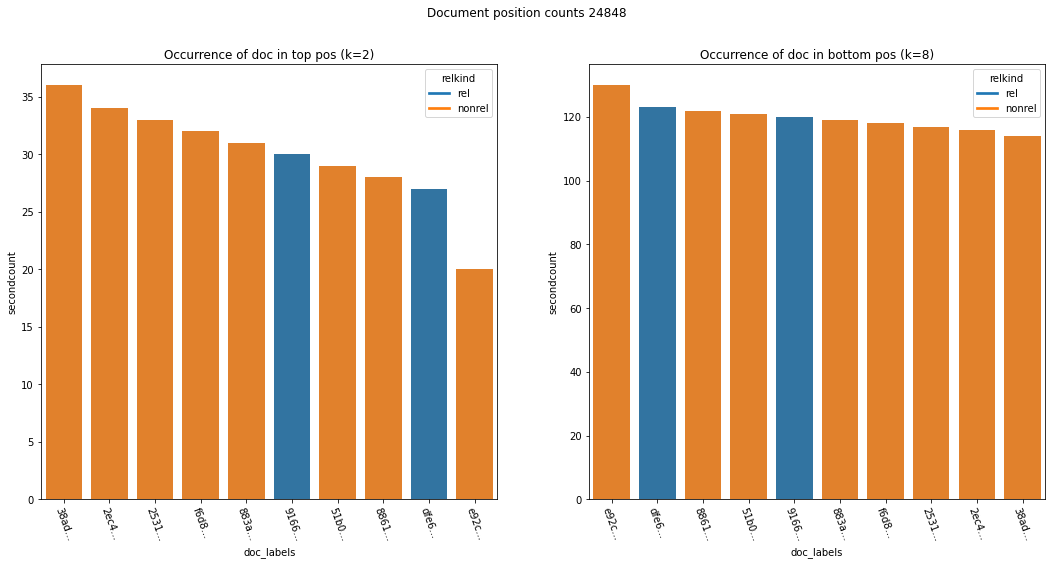

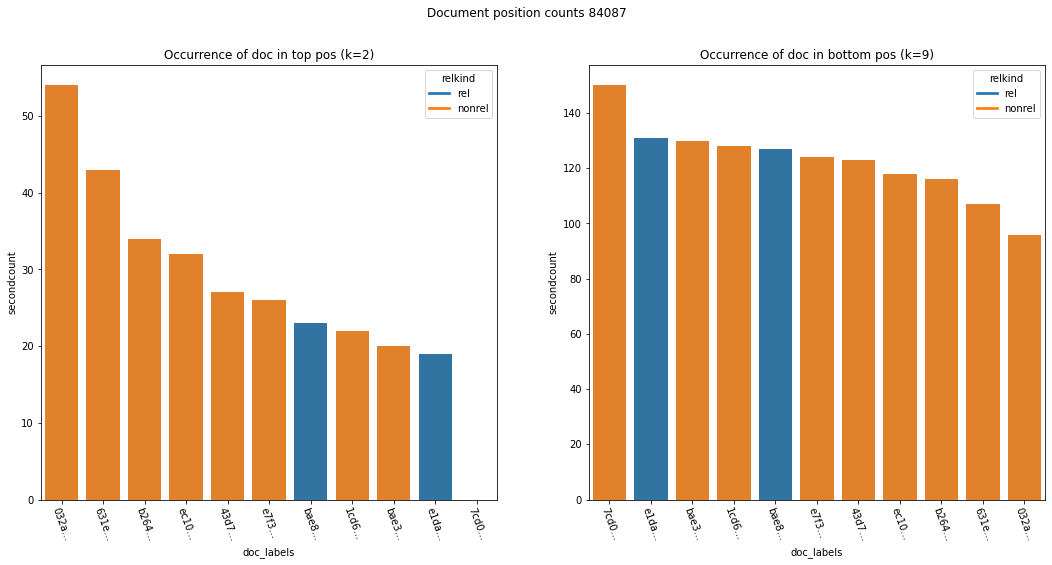

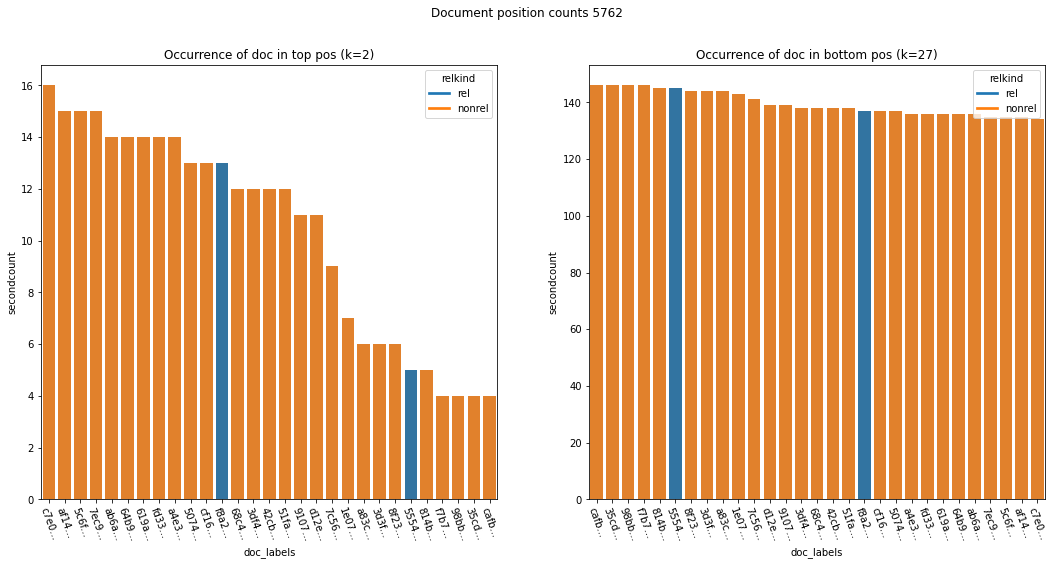

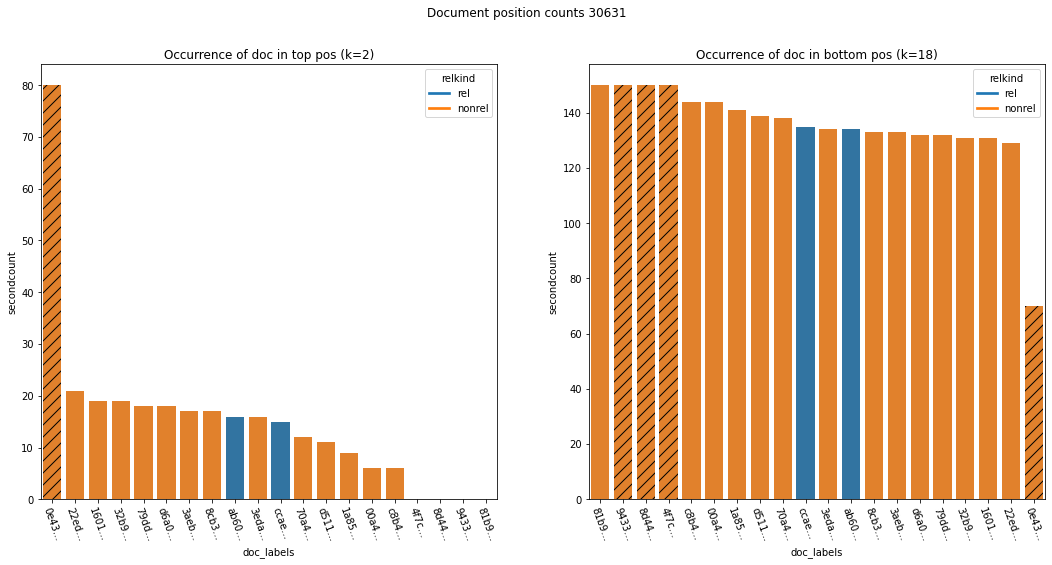

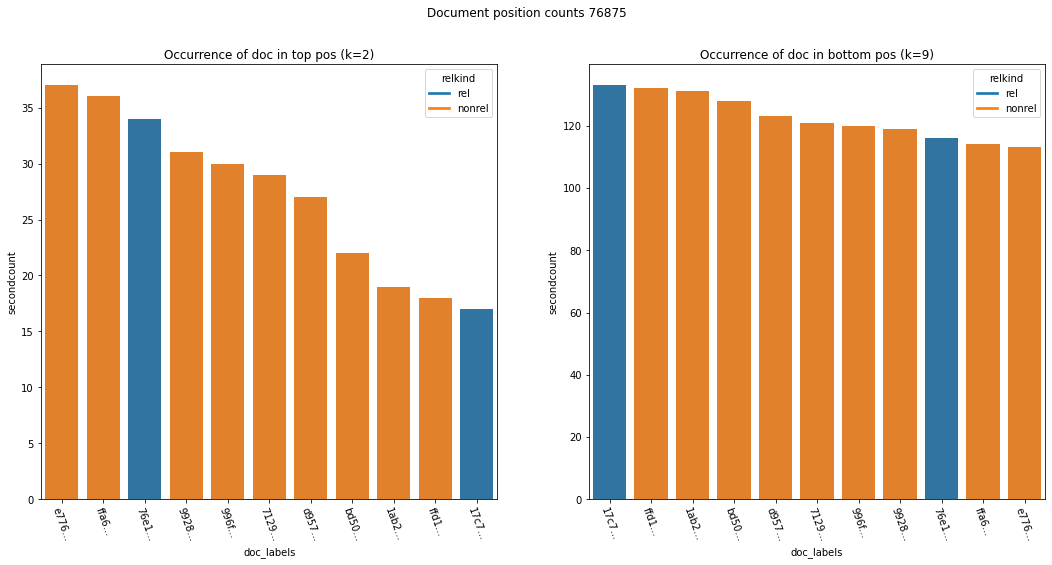

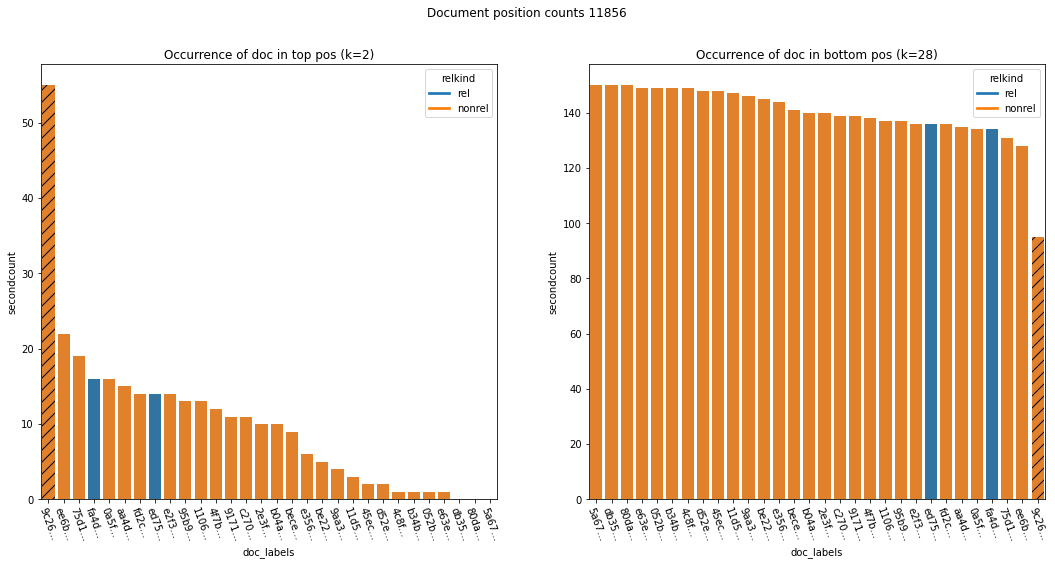

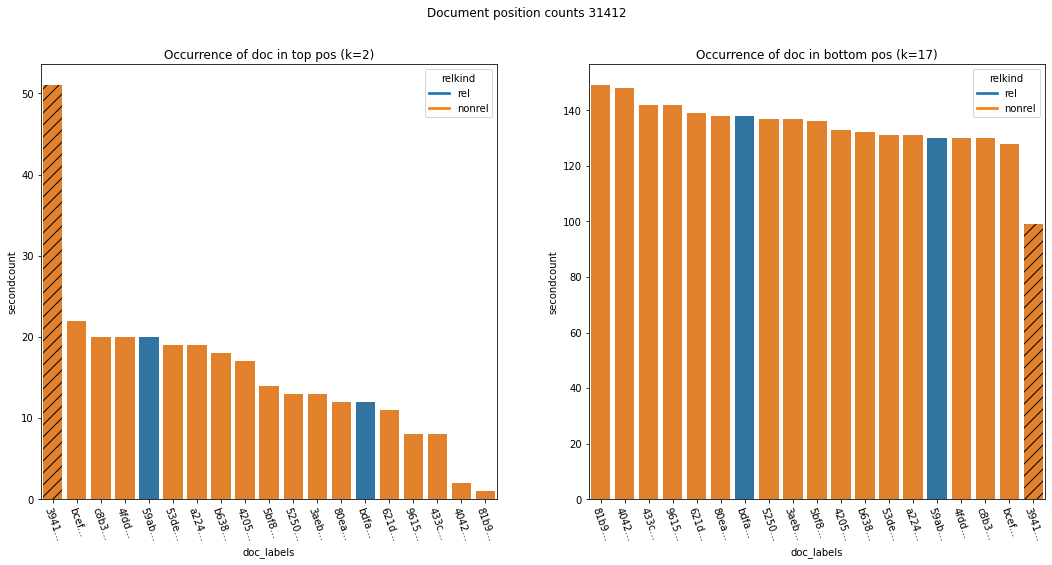

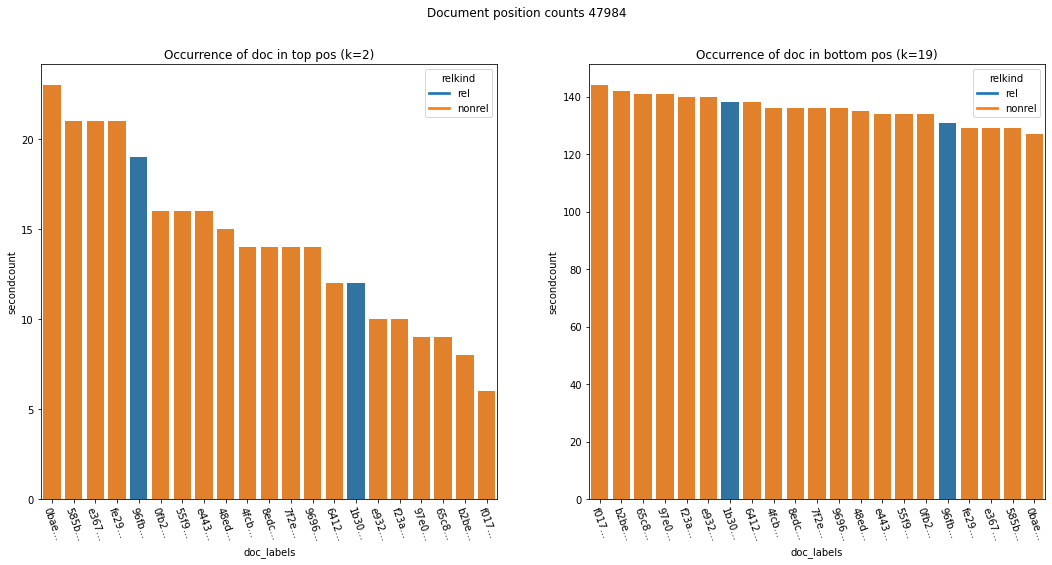

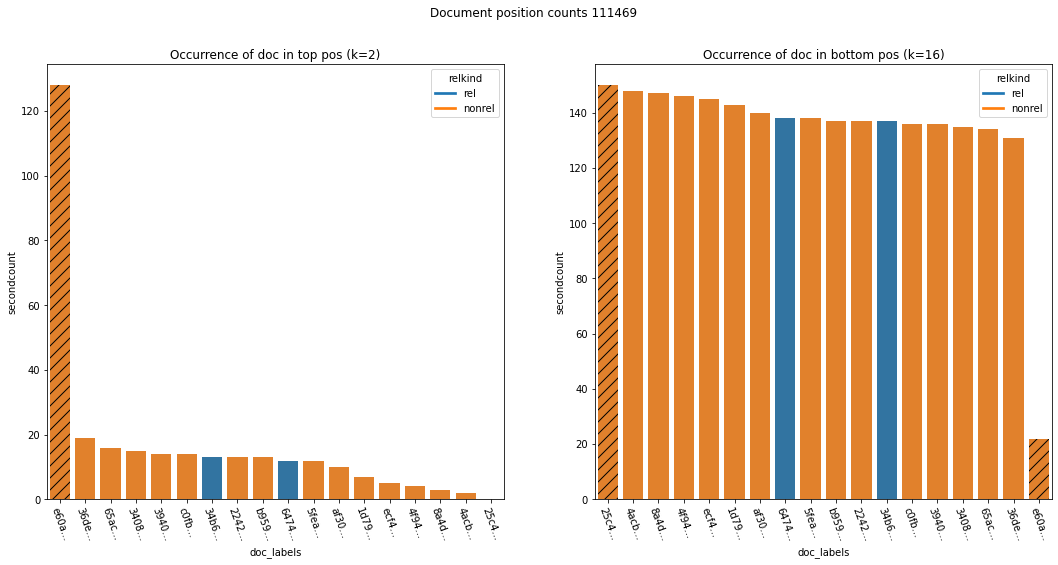

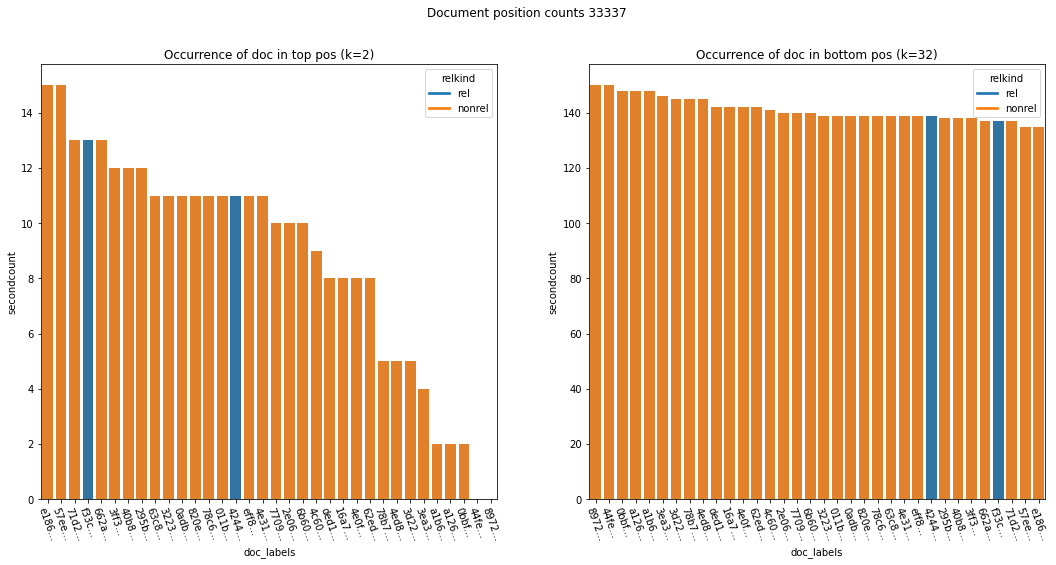

In [142]:
for qid in edf.tail(10).qid.to_list():
    plot_doc_pos_count_for_qid(qid, rdf, reldf, no_author_ids=noauth_docs)